In this notebook we're going to add the target variable. The target variable is defined by ourselfes - based on:
- research
- data analysis
- clustering

We detected 2 main infringements:
- hosts without license offering short term stays (under 32 days)
- hosts who claim they're private but have more than 3 listings 

We are now going to add a column (suspicious_or_not):
- 0: none of the mentioned infringements detected
- 1: either one or even both of the mentioned infringements detected

At the end of this notebook we're going to clean the dataset from all calculated fields (either calculated by ourselves of by insideairbnb!) except for our target variable. 

The idea is that our model should (hopefully) classify correctly based only on information that every normal user can easily get from the listing's airbnb website, without background knowledge or calculations!

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

c = ['#8e9aaf', '#cbc0d3', '#efd3d7', '#feeafa', '#dee2ff']
c3 = ['#efd3d7', '#ecccd0', '#eac6cb', '#e9c2c7', '#e7bcc2', '#e5b7bd', '#e3b1b8', '#e1aeb5', '#dfa7af', '#dea3ab', '#dc9fa8', '#da9aa3', '#d8949e', '#d7929c']

In [2]:
# load the data
bcn_original = pd.read_csv('../data/listings_bcn.csv')
scraped_host_type = pd.read_csv('../data/airbnb2.csv')

In [3]:
# join both datasets
scraped_host_type.rename(columns = {'url':'listing_url'}, inplace = True)
bcn=bcn_original.merge(scraped_host_type, on='listing_url', how='outer')
bcn = bcn.drop(['Unnamed: 0'], axis=1)

In [4]:
# remove all rows with NaN values in host_type column
bcn = bcn.dropna(subset=['host_type'])

In [5]:
# remove all rows with not_found values in host_type column
bcn = bcn[bcn['host_type']!='not_found']

In [6]:
# "impute" missing license with "no license" - but only in a new columns that is going to be deleted later again
bcn['license2'] = bcn['license'].fillna('no license')

In [7]:
def is_valid_license(license):
    if 'HUTB' in license:
        return 'ok'
    if 'HB' in license:
        return 'ok'
    if 'AJ' in license:
        return 'ok'
    elif 'exempt' in license.lower():
        return 'claims exempt'
    else:
        return 'no license'

In [8]:
# add status_license column
bcn['status_license'] = bcn.apply(lambda row: is_valid_license(row['license2']), axis=1)

In [9]:
bcn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11340 entries, 0 to 11453
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11340 non-null  int64  
 1   listing_url                                   11340 non-null  object 
 2   scrape_id                                     11340 non-null  int64  
 3   last_scraped                                  11340 non-null  object 
 4   source                                        11340 non-null  object 
 5   name                                          11334 non-null  object 
 6   description                                   11285 non-null  object 
 7   neighborhood_overview                         6860 non-null   object 
 8   picture_url                                   11340 non-null  object 
 9   host_id                                       11340 non-null  int6

In [10]:
# add own calculation of total listings
bcn['total_listings'] = bcn.groupby('host_id')['id'].transform('size')

In [11]:
def license_infringement(row):
    if row['status_license'] == 'ok':
        return 0
    if row['status_license'] == 'no license' and row['minimum_nights'] >31:
        return 0
    if row['status_license'] == 'claims exempt' and row['minimum_nights'] >31:
        return 0
    else:
        return 1

In [12]:
#add column license infringement detected or not
bcn['license_infringement'] = bcn.apply(lambda row: license_infringement(row), axis=1)

In [13]:
def claim_private_infringement(row):
    if row['host_type'] == 'private' and row['total_listings'] >3:
        return 1
    else:
        return 0

In [14]:
#add column claim private infringement detected or not
bcn['claim_private_infringement'] = bcn.apply(lambda row: claim_private_infringement(row), axis=1)

In [15]:
def suspicious_or_not(row):
    if row['license_infringement'] == 0 and row['claim_private_infringement'] == 0:
        return 0
    else:
        return 1

In [16]:
# add target column
bcn['suspicious_or_not'] = bcn.apply(lambda row: suspicious_or_not(row), axis=1)

In [17]:
#double-check
bcn[['host_type', 'total_listings', 'claim_private_infringement', 'status_license', 'minimum_nights', 'license_infringement', 'suspicious_or_not']].head(30)

,host_type,total_listings,claim_private_infringement,status_license,minimum_nights,license_infringement,suspicious_or_not
0,private,1,0,no license,1,1,1
1,private,1,0,claims exempt,2,1,1
2,private,4,1,ok,4,0,1
3,commercial,6,0,ok,1,0,0
4,private,1,0,claims exempt,2,1,1
5,private,8,1,ok,1,0,1
6,private,2,0,ok,3,0,0
7,commercial,27,0,no license,32,0,0
8,commercial,84,0,ok,3,0,0
9,private,1,0,no license,2,1,1


In [18]:
# check for distribution of target variable
bcn['suspicious_or_not'].value_counts(normalize=True)

suspicious_or_not
0    0.543298
1    0.456702
Name: proportion, dtype: float64

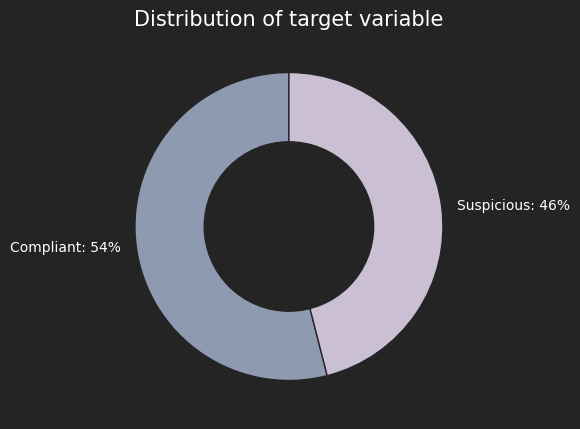

In [19]:
names =['Compliant: 54%', 'Suspicious: 46%']
sizes = [54,46]
fig = plt.figure()
fig.set_size_inches(8,5)
fig.patch.set_facecolor('#242424')
plt.rcParams['text.color'] = 'white'
plt.rcParams
my_circle=plt.Circle( (0,0), 0.55, color='#242424')
plt.pie(x=sizes, labels=names, colors=['#8e9aaf', '#cbc0d3'], startangle=90, wedgeprops={"edgecolor":'#242424'})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(
    label="Distribution of target variable", 
    fontdict={"fontsize":15})
plt.show()

In [20]:
bcn['host_type'].value_counts(normalize=True)

host_type
private       0.508642
commercial    0.491358
Name: proportion, dtype: float64

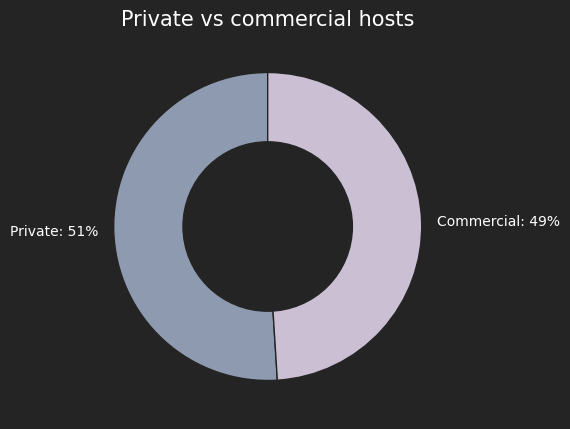

In [21]:
names =['Private: 51%', 'Commercial: 49%']
sizes = [51,49]
fig = plt.figure()
fig.set_size_inches(8,5)
fig.patch.set_facecolor('#242424')
plt.rcParams['text.color'] = 'white'
plt.rcParams
my_circle=plt.Circle( (0,0), 0.55, color='#242424')
plt.pie(x=sizes, labels=names, colors=['#8e9aaf', '#cbc0d3'], startangle=90, wedgeprops={"edgecolor":'#242424'})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(
    label="Private vs commercial hosts", 
    fontdict={"fontsize":15})
plt.show()

#### To do:
- train test split
- preprocessing
- baseline model

In [22]:
bcn.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [23]:
# delete all calculated fields to proceed with a clean dataset

bcn_ready_for_model = bcn.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'host_url', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'status_license', 'total_listings', 'license_infringement',
       'claim_private_infringement', 'license2'], axis=1)

In [24]:
bcn_ready_for_model.shape

(11340, 52)

In [25]:
bcn_ready_for_model.reset_index(drop=True)

,id,name,description,neighborhood_overview,picture_url,host_id,host_name,host_since,host_location,host_about,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,host_type,suspicious_or_not
0,13977576,Habitación individual es Barcelona,Mi alojamiento es bueno para aventureros y via...,NaN,https://a0.muscache.com/pictures/7a6e9767-bd4e...,64903899,Carolina,2016-03-29,"Paris, France",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,private,1
1,42105584,Habitación M&D,<b>License number</b><br />Exempt,NaN,https://a0.muscache.com/pictures/7342e586-6ea5...,333969184,Midian,2020-02-06,"Barcelona, Spain",Soy brasileña soy buena persona,...,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,private,1
2,33727898,Spacious and bright apartment next to Plaza Es...,Hi friends! Welcome to this apartment located ...,The apartment is located in the Eixample quart...,https://a0.muscache.com/pictures/44066458-5997...,251710733,Magda,2019-03-28,NaN,"Hello! I'm Magda, nice to meet you! I wish you...",...,4.97,4.97,5.00,5.00,4.83,4.73,HUTB-008684,f,private,1
3,44995311,"Single Room, City Center, Private Bathroom",Goya Hostel is a hostel located in the center ...,"The Eixample, which translates as ""widening"" b...",https://a0.muscache.com/pictures/af651bc2-8dff...,363074093,Hostal,2020-08-18,"Barcelona, Spain","Ubicado en el Eixample de Barcelona, junto a P...",...,4.91,4.73,4.91,4.64,4.91,4.73,HUTB-265656,t,commercial,0
4,15763812,HABITACIÓN PLAZA ESPAÑA,"Lugares de interés: Poble Espanyol, CaixaForum...",NaN,https://a0.muscache.com/pictures/1bccbbbc-4b78...,101927904,James,2016-10-31,"Barcelona, Spain","Casa de familia amable, agradable y servicial.",...,4.90,4.94,4.96,4.67,4.88,4.60,Exempt,t,private,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,25348381,Habitación doble en ático con terraza,Double room available near Plaza España (8 min...,Sants is a neighborhood in the southern part o...,https://a0.muscache.com/pictures/5565f452-d73f...,56223475,Álvaro,2016-01-26,"Barcelona, Spain",I live in Barcelona but I was born in Bilbao. ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,private,1
11336,29406276,New and bright apartment near Sagrada Familia,Jazz BCN Apartments is a new concept of acco...,sagrada familia - 1045 m<br />Torre Agbar - 1...,https://a0.muscache.com/pictures/prohost-api/H...,158023606,Habitat Apartments,2017-11-09,"Barcelona, Spain",Habitat Apartments is a professional vacation ...,...,4.65,4.69,4.49,4.56,4.62,4.58,HUTB-011343,t,commercial,0
11337,41223936,Habitación luminosa. Ideal para recorrer BCN,Habitación (3mx3m) en piso a compartir. Cama ...,Es un barrio donde se encuentran más residente...,https://a0.muscache.com/pictures/c3e56aef-d8d3...,323550676,Guillermo,2020-01-02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,private,1
11338,13562606,Double room at 10min of Parque Guell/Bunkers,Double room in a residential quiet neighborhoo...,"The neighboroud is quiet, we are not in the ci...",https://a0.muscache.com/pictures/07824361-9c62...,7358932,Alexandra,2013-07-08,"Barcelona, Spain",Hola! Soy Alexandra y vivo en Barcelona. Soy u...,...,4.92,4.85,4.99,4.96,4.60,4.78,NaN,f,private,1


In [26]:
bcn_ready_for_model.to_csv('df_modelling.csv') 